<h1> 创建最佳梦幻篮球阵容 </h1>

<h2> 简介 </h2>

梦幻篮球和梦幻体育一般来说是一个非常受欢迎的游戏,参与者通过从即将进行的真实比赛中虚拟选择球员来组建阵容并相互竞争。通常,目标是组建最好的全明星队伍,这意味着参与者可以从同一联盟中不同的职业球队中选择球员来组建自己的虚拟球队。

一支篮球队通常由五名球员组成:控球后卫(PG)、得分后卫(SG)、小前锋(SF)、大前锋(PF)和中锋(C)。每个球员被分配到这些位置后,在篮球比赛中可能有不同的特点和目标。得分后卫可能专注于得分,而控球后卫的目标可能是执行比赛计划并高效分配球。为了帮助比较不同位置的球员,我们需要找到一个评估每个球员表现的通用指标 -- 我们将使用梦幻积分来实现这一点。

在后续的例子中,我们将扩展优化模型以反映主要网站上的实际梦幻篮球比赛。

<h2> 目标和先决条件 </h2>

在这个例子中,我们将扮演篮球教练的角色,学习如何在梦幻篮球的背景下找到最佳的NBA球员阵容。目标是选择五名将在2017年12月25日的NBA比赛中表现最好的球员,同时满足球员和位置资格以及预算约束。

我们旨在展示机器学习和数学优化是如何紧密相连的,以及它们如何结合起来得出最佳决策。从数据集开始,我们将应用机器学习技术来预测篮球运动员的表现。但在考虑到问题约束时,直接利用这些预测来做出球员选择并不简单。这就是数学优化和Gurobi优化器在通过构建和解决一个混合整数规划(MIP)问题来最大化阵容的**总梦幻积分**时表现出色的地方。

这个例子适合对数学优化初学者,他们可能有一些数据处理和预测建模的经验,并且有使用Python的经验。

所示问题需要安装以下Python包:

- **pandas** 用于数据分析和处理
- **numpy** 用于计算
- **matplotlib** 和 **seaborn** 用于绘图和可视化信息
- **scikit-learn** 用于访问数据科学预测工具
- **gurobipy** 用于利用Gurobi构建和解决优化问题

<h2> 问题陈述和解决方法 </h2>

给定2016-2017和2017-2018赛季NBA球员的常规赛历史表现(数据统计),每个球员的合格位置,以及我们允许为球队花费的总薪资限制,选择将在2017-2018赛季圣诞节当天的NBA比赛中表现最好的五名NBA球员。

在当天将要比赛的合格球员中,我们需要选择一名控球后卫、一名得分后卫、一名小前锋、一名大前锋和一名中锋。

问题的解决方案包括两个部分: 1) **梦幻积分预测** 和 2) **阵容优化**。

<h3> 梦幻积分预测 </h3>

让我们先加载解决问题所需的库。

In [ ]:
# %pip install gurobipy

In [2]:
import pandas as pd                                       #导入pandas
import numpy as np                                        #导入numpy
import matplotlib.pyplot as plt                           #导入matplotlib
import seaborn as sns                                     #导入seaborn
from sklearn.model_selection import train_test_split      #导入scikit-learn的数据拆分函数
from sklearn.linear_model import LinearRegression         #导入scikit-learn的线性回归函数
from sklearn.neural_network import MLPRegressor           #导入scikit-learn的神经网络函数
from sklearn.ensemble import GradientBoostingRegressor    #导入scikit-learn的梯度提升回归函数
from sklearn.metrics import mean_squared_error            #导入scikit-learn的均方误差函数用于模型评估
from sklearn.model_selection import cross_validate        #导入scikit-learn的交叉验证函数
import gurobipy as gp                                     #导入Gurobi


我们将使用来自[Kaggle](https://www.kaggle.com)的两个公开数据集。第一个数据集包含球员和球队的历史表现信息,将用于训练和测试我们的预测模型。第二个数据集包括球员的薪资以及他们的合格位置。请注意,这里的*薪资*是由举办梦幻体育比赛的网站确定的,与球员实际支付的薪资无关。

我们对这两个数据集进行了轻微的预处理,以确保球员姓名的一致性,并仅包括我们项目所需的列。此外,我们仅使用运动员在比赛中至少出场3分钟的观察值。两个更新版本的数据集都可以在我们的**仓库**中找到。

我们首先读取boxscores数据集,该数据集包括从2016-2017赛季到2017年12月25日比赛的所有球员的常规赛表现。对于该日期之前的比赛,我们使用以下公式计算每个球员的总梦幻积分:

<font size="3">$FP = Points + 1.5 \times Assists - 0.5 \times Turnovers + Steals + 2 \times Blocks + 1.25 \times Rebounds + 0.5 \times ThreePointer$</font>

此值已在**boxscores_dataset.csv**文件中计算。

In [3]:
# boxscores = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/boxscores_dataset.csv')     #加载boxscores数据集
# 本地运行
boxscores = pd.read_csv('boxscores_dataset.csv')     #加载boxscores数据集
boxscores = boxscores[(boxscores.playMin>=3) | (boxscores.playMin.isnull())]

一般来说,梦幻积分与每个球员的利用率和效率相关,我们可以通过可视化来检查这些关系。以下是一些散点图,但请随意添加更多的可视化以更深入地了解数据中的情况。

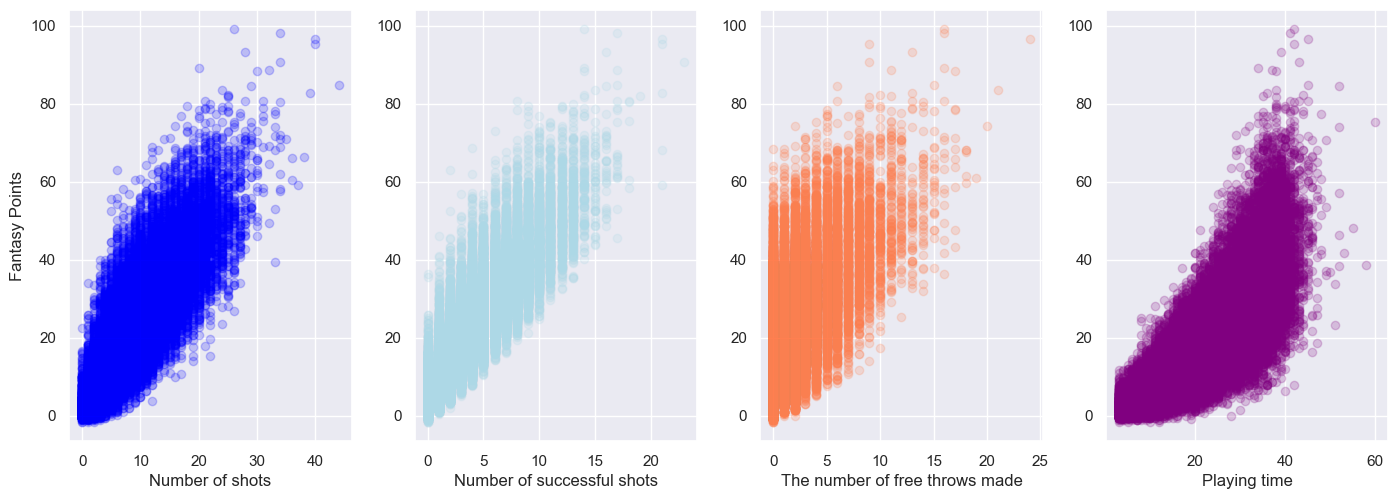

In [9]:
fig, (FGA, FGM, FTM, Min) = plt.subplots(1, 4, figsize=(14,5))
fig.tight_layout()

FGA.scatter(boxscores['playFGA'], boxscores['FantasyPoints'], c='blue', alpha = .2)
FGM.scatter(boxscores['playFGM'], boxscores['FantasyPoints'], c='lightblue', alpha = .2)
FTM.scatter(boxscores['playFTM'], boxscores['FantasyPoints'], c='coral', alpha = .2)
Min.scatter(boxscores['playMin'], boxscores['FantasyPoints'], c='purple', alpha = .2)

FGA.set_xlabel('Number of shots')
FGM.set_xlabel('Number of successful shots')
FTM.set_xlabel('The number of free throws made')
Min.set_xlabel('Playing time')

FGA.set_ylabel('Fantasy Points');

下面是球员在之前比赛中的真实梦幻积分的分布图:

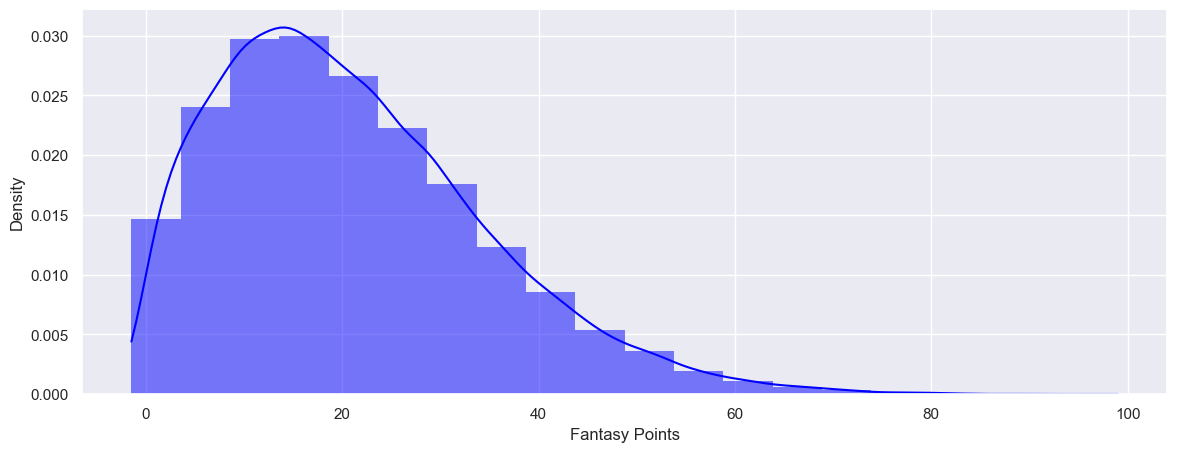

In [8]:
hplot = sns.histplot(boxscores['FantasyPoints'], color="blue", label="Fantasy Points", kde=True, stat="density", linewidth=0, bins=20)
hplot.set_xlabel("Fantasy Points", fontsize = 12)
hplot.set_ylabel("Density", fontsize = 12)
sns.set(rc={"figure.figsize":(14, 5)})

在构建我们的预测模型时,在比赛中得分的梦幻积分是一个很好的目标(或独立)变量。那么模型的特征呢?

一种方法是使用球员前几场比赛的boxscore数据,找到这段时间内关键统计数据的平均值。我们将从以下三场比赛的平均值开始:得分、助攻、失误、抢断、盖帽、总篮板、投篮次数、罚球次数、2分球命中率、3分球命中率、罚球命中率、上场时间、休息天数和真实梦幻积分。

例如,在第$k$场比赛中,助攻的计算公式为:

<font size="4">$平均助攻_k = \frac{助攻_{k-1}+助攻_{k-2}+助攻_{k-3}}{3}$</font>

In [10]:
horizon=3

for column_name in ['playPTS','playAST','playTO','playSTL','playBLK','playTRB','playFGA','playFTA','play2P%','play3P%','playFT%','playMin','teamDayOff','FantasyPoints']:
    boxscores['moving' + column_name] = boxscores.groupby(['playDispNm'])[column_name].transform(lambda x: x.rolling(horizon, 1).mean().shift(1))                           #数值特征的滞后移动平均值

这为我们提供了一组特征,尽管我们仍然希望对我们的预测模型进行特征选择。更改滞后游戏的数量可能会提高您的预测模型 -- 所以请尝试一下!

由于我们使用的是滞后平均值,因此每个球员的第一场比赛没有任何历史信息,因此我们删除这些观察值。

In [11]:
boxscores.dropna(subset = ["movingplayPTS"], inplace=True)               #删除每个球员的第一个观察值

为了开始特征选择,我们可以查看新派生变量之间的相关性,如下所示:

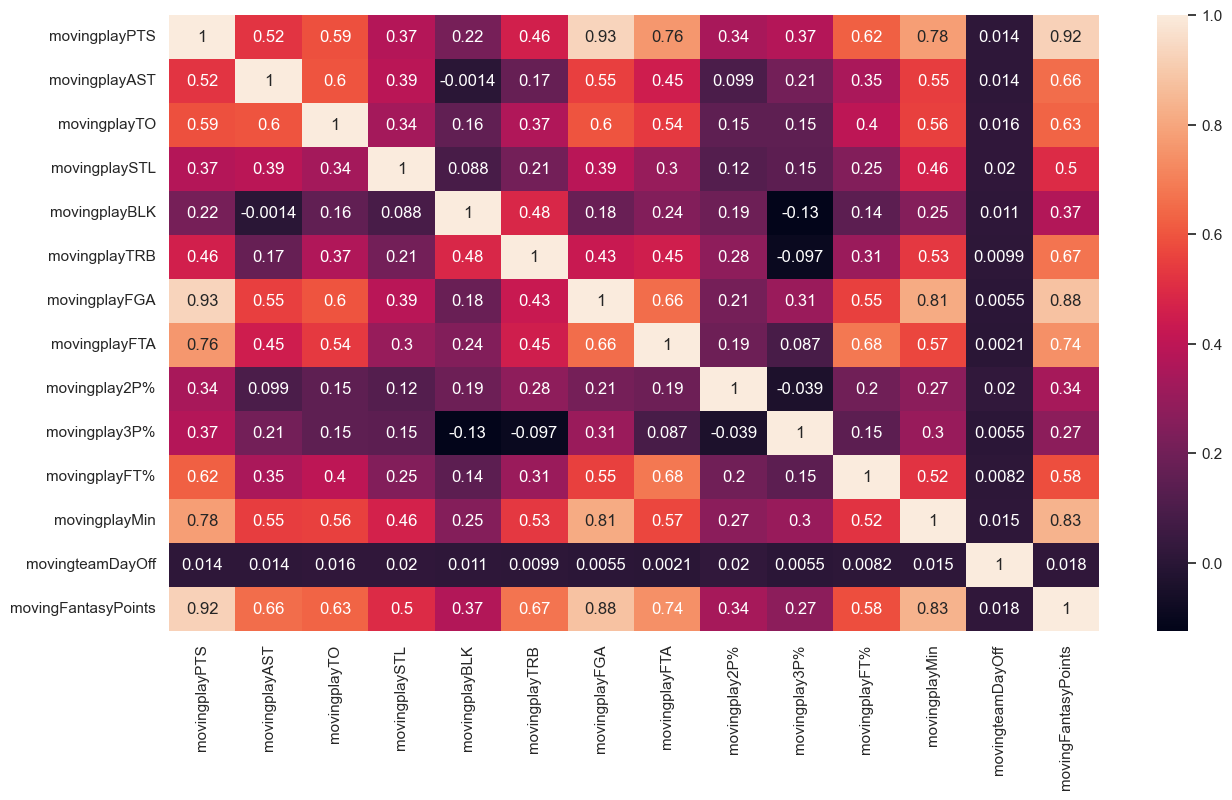

In [12]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(boxscores[['movingplayPTS', 'movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFGA','movingplayFTA','movingplay2P%','movingplay3P%','movingplayFT%','movingplayMin','movingteamDayOff','movingFantasyPoints']].corr(),annot=True)
plt.show()

我们观察到一些特征高度相关。例如,罚球次数的平均值与得分平均值高度相关。

我们还在研究两个分类变量的利用情况。具体来说,当前比赛是主场还是客场,以及球员是首发还是替补。我们将分类变量转换为0-1变量。

In [13]:
boxscores['dummyTeamLoc'] = pd.get_dummies(data=boxscores['teamLoc'],drop_first=True)    #1表示主场比赛,0表示客场比赛
boxscores['dummyplayStat'] = pd.get_dummies(data=boxscores['playStat'],drop_first=True)  #1表示球员首发,0表示球员替补

现在数据集已经更新,我们开始预测将在2017年12月25日比赛的球员的梦幻积分。

In [14]:
forecasting_data = boxscores[boxscores.gmDate != '2017-12-25']  #用于模型训练,我们排除2017年12月25日的观察值

我们将数据集拆分为80%的训练数据和20%的测试数据。为了预测,我们尝试了三种模型:线性回归、神经网络和梯度提升回归。除了热图,我们还基于统计显著性测试并使用方差膨胀因子(VIF)检查多重共线性。交叉验证也用于识别潜在的过拟合。

我们将用于预测模型的特征是球员的平均助攻、失误、抢断、盖帽、总篮板、罚球次数、罚球命中率以及球员是否首发或替补。

In [15]:
X = forecasting_data[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]  #选择用于模型训练的特征
y = forecasting_data['FantasyPoints']  #目标集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)      #数据集拆分

linear_regressor = LinearRegression()                                                         #加载线性回归模型
linear_regressor.fit(X_train, y_train)                                                        #训练线性回归模型
linear_regression_validation = cross_validate(linear_regressor, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

mlp = MLPRegressor(hidden_layer_sizes=(5,5), activation='relu')                               #加载神经网络
mlp.fit(X_train,y_train)                                                                      #训练具有ReLU函数和两个隐藏层(每层5个节点)的神经网络
mlp_validation = cross_validate(mlp, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

gb = GradientBoostingRegressor()                                                              #加载梯度提升回归模型
gb.fit(X_train, y_train)                                                                      #训练梯度提升模型
gb_validation = cross_validate(gb, X_train, y_train, cv=5, return_train_score=True, return_estimator=True)

In [16]:
gb_validation['test_score']                            #打印每个折叠的交叉验证测试得分

array([0.50931889, 0.499014  , 0.48132659, 0.49754616, 0.50075732])

我们观察到模型在每个折叠中的表现一致。现在,为了评估模型的性能,我们计算它们的均方误差(MSE)值。

In [17]:
linear_regression_predictions = linear_regressor.predict(X_test)                              #基于测试集进行线性回归模型的预测
mlp_predictions = mlp.predict(X_test)                                                         #基于测试集进行神经网络模型的预测
gb_predictions = gb.predict(X_test)                                                           #基于测试集进行梯度提升模型的预测

linear_regression_mse = mean_squared_error(y_test, linear_regression_predictions)             #计算线性回归模型的MSE
mlp_mse = mean_squared_error(y_test, mlp_predictions)                                         #计算神经网络模型的MSE
gb_mse = mean_squared_error(y_test, gb_predictions)                                           #计算梯度提升模型的MSE

results = {'线性回归':[linear_regression_mse],'ReLU神经网络':[mlp_mse],'梯度提升回归':[gb_mse]}
modeling_results = pd.DataFrame(data=results,index=['MSE'])

modeling_results

,线性回归,ReLU神经网络,梯度提升回归
MSE,91.077312,90.473389,90.668092


每种模型类型的表现都相似,如其均方误差值所示。此外,以下图显示了预测值误差与预测梦幻积分的关系:

Text(967.9632352941177, 0.5, 'Gradient boosting residual')

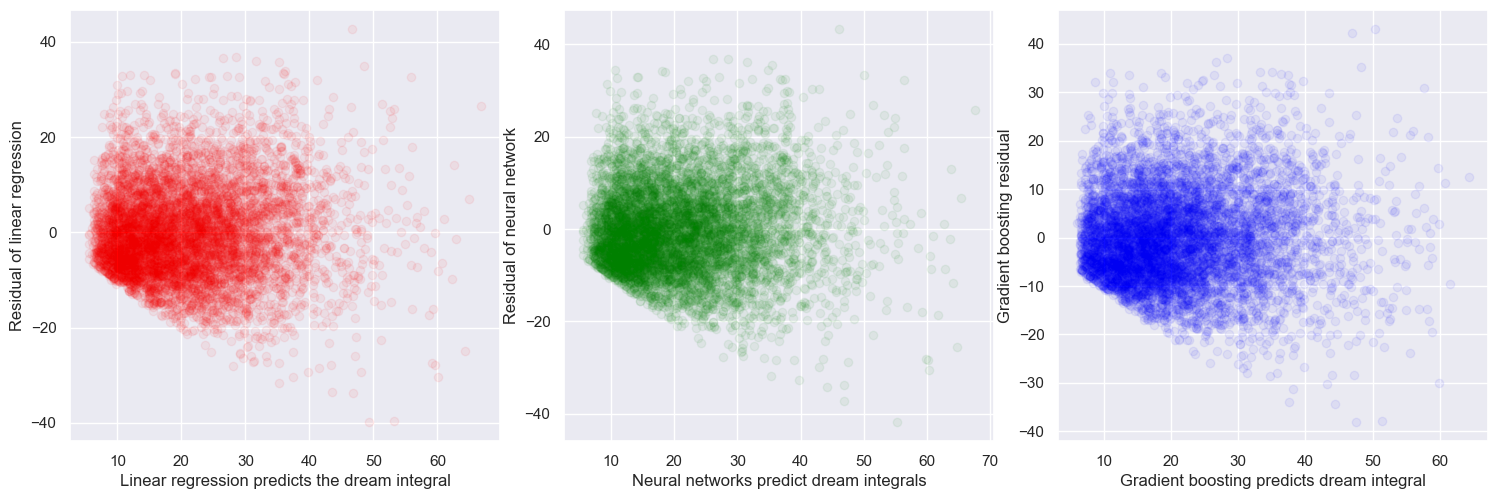

In [18]:
fig, (LR, FNN, GBR) = plt.subplots(1, 3,figsize=(15,5));
fig.tight_layout()

LR.scatter(x = linear_regression_predictions, y = y_test - linear_regression_predictions,color='red',alpha=0.06)
FNN.scatter(x = mlp_predictions, y = y_test - mlp_predictions, color='green',alpha=0.06)
GBR.scatter(x = gb_predictions, y = y_test - gb_predictions, color='blue',alpha=0.06)

LR.set_xlabel('Linear regression predicts the dream integral')
FNN.set_xlabel('Neural networks predict dream integrals')
GBR.set_xlabel('Gradient boosting predicts dream integral')

LR.set_ylabel('Residual of linear regression')
FNN.set_ylabel('Residual of neural network')
GBR.set_ylabel('Gradient boosting residual')

从上面的图和测试得分中可以看出,我们的模型只能部分解释梦幻积分的方差。这是可以预期的,因为有很多因素会影响球员的表现。略微领先的是梯度提升回归模型,因此我们将重新拟合该模型到完整数据集,并使用它来预测梦幻积分。

之后,我们将预测的梦幻积分附加到薪资数据中,以设置优化部分的解决方案。

In [ ]:
gb_final = GradientBoostingRegressor(random_state=4)                                                             
gb_final.fit(X, y)   

optimization_dataset = boxscores
optimization_dataset['PredictedFantasyPoints'] = gb_final.predict(boxscores[['movingplayAST','movingplayTO','movingplaySTL','movingplayBLK','movingplayTRB','movingplayFTA','movingplayFT%','dummyplayStat']]) 

# player_results = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/fantasy_basketball/target_games.csv')
player_results = pd.read_csv('target_games.csv')

predicted_fantasy_points = (
    optimization_dataset.query("gmDate == '2017-12-25'")
    [["playDispNm", "PredictedFantasyPoints"]]
)

player_results = pd.merge(
    left = player_results,
    right = predicted_fantasy_points,
    left_on = "Player",
    right_on = "playDispNm",
)

我们还计算了另一个列,即每个球员的预测梦幻积分除以薪资。

In [23]:
pd.set_option('display.expand_frame_repr', False)
player_results['Points/Salary Ratio'] = 1000*player_results['PredictedFantasyPoints']/player_results['Salary']    #我们将梦幻积分与薪资比率乘以1000以便更好地可视化
player_results.sort_values(by='PredictedFantasyPoints',ascending=False).head(5)

,Player,Pos,Team,Opp,Salary,playDispNm,PredictedFantasyPoints,Points/Salary Ratio
4,Joel Embiid,C,PHI,@ NYK,9500,Joel Embiid,51.313689,5.401441
0,James Harden,PG,HOU,@ OKC,11100,James Harden,48.809577,4.397259
1,LeBron James,SF,CLE,@ GSW,11000,LeBron James,48.149718,4.377247
2,Russell Westbrook,PG,OKC,vs HOU,10900,Russell Westbrook,44.007224,4.037360
3,Kevin Durant,SF,GSW,vs CLE,10500,Kevin Durant,43.438575,4.137007


那么有多少潜在的阵容组合呢?很多。

$24PG \times 22SF \times 22SG \times 19PF \times 9C = 1,986,336$ 组合

使用暴力方法计算每个阵容的总梦幻积分将花费非常长的时间。我们还需要考虑薪资限制(例如$30,000)。贪婪方法(即总是选择最好的球员)会选择前三名梦幻积分最高的球员(Embiid, James和Harden),但随后会发现薪资上限被违反。使用梦幻积分与薪资比率也可能导致同样的问题。

这就是优化最有优势的地方,因为它能够非常高效地探索选项空间,并且可以证明您得到了最佳解决方案。

<h3> 最佳阵容选择 </h3>

现在我们已经有了球员的预测,我们可以开始确定最佳阵容。

首先,我们将做一些定义,这些定义有助于我们建立优化模型。首先,下标$i$将用于表示我们可以选择的所有球员中的个体球员。

**输入参数**

$p_{i}$: 球员$i$的预测梦幻积分

$s_{i}$: 球员$i$的薪资

$S$: 我们的总可用薪资

以下是设置索引和参数的代码:

In [24]:
indices = player_results.Player
points = dict(zip(indices, player_results.PredictedFantasyPoints))
salaries = dict(zip(indices, player_results.Salary))
S = 30000

m = gp.Model();        # 这定义了我们将添加到的模型,以完成公式

Set parameter LicenseID to value 2601452


**决策变量**

这个问题的目标是确定每个球员是否在我们的最终阵容中。这是优化中使用*二进制变量*的一个例子,用于表示我们要做出的**是**或**否**决策。这建模为$y_{i} = 1$: 如果选择球员$i$; 否则$y_{i} = 0$。

以下是在gurobipy中向我们的模型添加一组决策变量的代码:

In [30]:
y = m.addVars(player_results.Player, vtype=gp.GRB.BINARY, name="y")

**目标函数**

我们问题的目标是最大化我们阵容的总梦幻积分。由于我们使用的是二进制变量,如果选择了球员($y_{i} = 1$),则他们的预测积分将通过$p_{i} \cdot y_{i}$贡献给我们的阵容。如果$y_{i} = 0$,则$p_{i} \cdot y_{i} = 0$。对所有球员求和将给我们要最大化的函数,写作:

\begin{align}
 Max \hspace{0.2cm} Z = \sum p_{i} \cdot y_{i}
\end{align}

以下是使用gurobipy中的quicksum函数编写求和的一种方法(您可以使其他方法工作),我们将其添加到我们的模型中作为目标函数:

In [31]:
# 由于我们正在最大化积分,这里的最后一个参数是GRB.MAXIMIZE
m.setObjective(gp.quicksum(points[i]*y[i] for i in indices), gp.GRB.MAXIMIZE)

**约束条件**

我们需要确保每个位置都有且只有一名球员被分配。由于我们的决策变量都是0或1,我们可以通过为每个位置添加一个约束来建模,对合格球员(和决策变量)求和,要求该和等于1:

\begin{align}
\sum_{i \space eligible} y_{i} = 1
\end{align}

循环遍历位置将为每个位置添加一个约束,而quicksum函数中的条件将告诉模型仅在球员合格时对其求和:

In [ ]:
player_position_map = list(zip(player_results.Player, player_results.Pos))
for j in player_results.Pos:
    m.addConstr(gp.quicksum([y[i] for i, pos in player_position_map if pos==j])==1)

此外,我们需要确保总薪资不超过某个阈值:

\begin{align}
\sum s_{i} \cdot y_{i} \leq S
\end{align}

In [36]:
#所选球队的预算不得超过30,000
m.addConstr(gp.quicksum(salaries[i]*y[i] for i in indices) <= S, name="salary");       

现在我们已经将所有必需的部分添加到我们的优化模型中,我们可以开始求解。

In [37]:
m.optimize()  #我们优化我们的模型

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 97 rows, 96 columns and 2082 nonzeros
Model fingerprint: 0x90509d6e
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [7e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective 126.1046919
Presolve removed 91 rows and 57 columns
Presolve time: 0.00s
Presolved: 6 rows, 39 columns, 78 nonzeros
Found heuristic solution: objective 156.7777076
Variable types: 0 continuous, 39 integer (39 binary)

Root relaxation: objective 1.736178e+02, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent

上面的输出大部分可以暂时忽略,但在创建更大更复杂的模型时会提供有价值的信息。让我们关注最后两行,它们表示找到了一个最优解及其目标值。

我们需要从模型中提取解决方案,以找到选择的球员。使用getVars()获取每个决策变量的值,因此我们循环遍历决策变量,检查其值(使用.x)是否大于0。在循环中,我们记录每个选定球员的信息到一个数据框中。

In [ ]:
vars = m.getVars()

results = (
    player_results.iloc[[v.index for v in vars if v.x > 1e-6]][['Player','Pos','PredictedFantasyPoints','Salary']]
)
for i in results.index:
    print(vars[i].varname, vars[i].x)

print('总梦幻积分: ', m.objVal)

y[Joel Embiid] 1.0
y[Dario Saric] 1.0
y[Trevor Ariza] 1.0
y[Jarrett Jack] 1.0
y[Markieff Morris] 1.0
总梦幻积分:  171.91892913632245


由于比赛已经进行,我们还查找了2017年12月25日比赛中选定球员的真实梦幻积分,并将其添加到我们的结果数据框中。

In [40]:
results['True Fantasy Points'] = [53.5,17.25,28.5,15.5,29.25]
results

,Player,Pos,PredictedFantasyPoints,Salary,True Fantasy Points
4,Joel Embiid,C,51.313689,9500,53.50
19,Dario Saric,PF,40.505486,6200,17.25
36,Trevor Ariza,SG,26.354157,5000,28.50
43,Jarrett Jack,PG,27.780012,4600,15.50
49,Markieff Morris,SF,25.965585,4400,29.25


基于*这组初始预测*,最佳总梦幻积分为**$171.92$**,选择**Jarrett Jack**作为控球后卫,**Trevor Ariza**作为得分后卫,**Markieff Morris**作为小前锋,**Dario Saric**作为大前锋,**Joel Embiid**作为中锋,总薪资为$\$29,700$。

让我们快速回顾一下以*贪婪*方式组建阵容的想法,这意味着我们从*最佳可用*选择开始并重复。请注意,我们预测得分非常高的球员,如James Harden或Lebron James,并没有进入最佳阵容,因此追求高得分球员可能是次优的。

如果您重新排序薪资表,按预测积分与薪资比率排序,我们会看到PF Jordan Bell和PG Josh Hart位于列表顶部。但这些球员也不在最佳阵容中,因此即使使用该指标也可能导致次优解决方案。

这展示了数学优化的力量。我们的简单模型能够考虑超过200万种可能性,并得出一个最佳解决方案,如果我们在创建阵容时应用一些直观的决策规则,这个解决方案可能会被忽略。

In [41]:
m.dispose()
gp.disposeDefaultEnv()

Freeing default Gurobi environment


<h2> 结论 </h2>

在这个例子中,您学习了如何在梦幻体育的背景下优化您的篮球阵容。从球员数据开始,我们构建了预测NBA运动员未来梦幻积分的模型,然后开发了一个优化公式来计算在预算和位置资格约束条件下的最佳阵容。

通过这个例子,我们的目的是清楚地展示数据科学和数学优化之间的一些联系,从数据开始,以决策结束。我们还看到,即使应用合理的规则,做出次优决策也是很容易的。

我们还有一个更高级的梦幻篮球问题,它使用相同的预测元素,但扩展了优化部分,以反映流行网站上的真实梦幻篮球比赛。